# Лабораторная работа №7

##Задание

**Цель работы** - написать программу на языках Python, выполняющую построение и обучение классификатора изображений с помощью сверточных нейронных сетей, требуется подобрать безызбыточную архитектуру сети, работающей с допустимым уровнем ошибки и визуализировать процесс обучения моделей. Результаты работы привести в отчете.

##Импорт библиотек

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import random

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
from PIL import Image

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
import warnings

In [ ]:
import os

In [ ]:
from google.colab import files
from google.colab import drive

In [ ]:
# подключение диска

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/STUDY/магистратура курс 2/Нейронные сети/Lab_7/"

In [ ]:
# параметры графиков

palette = 'inferno'

colors = sns.color_palette(palette).as_hex()[:]

In [ ]:
import torch
from torch.utils.data import DataLoader

## Функции

In [ ]:
# визуализация процесса обучения

def acc_and_loss_visualization(history, colors):

  clrs = [
      colors[1],
      colors[len(colors) - 1]
    ]

  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  if (len(train_loss) < 5):
    print("The history is very short!")
    print("History length: ", len(train_loss))
    return

  epochs = range(1, len(train_loss) + 1)

  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_acc, label='Training Accuracy', color = clrs[0])
  plt.plot(epochs, val_acc, label='Validation Accuracy', color = clrs[1])
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_loss, label='Training Loss', color = clrs[0])
  plt.plot(epochs, val_loss, label='Validation Loss', color = clrs[1])
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
# отображение случайных изображений из директории
# на вход передается директория и кол-во изображений

def show_random_images(data_dir, num_images):

    # названия классов
    class_names = os.listdir(data_dir)

    # округляем количество изображений так, чтобы
    # "вписать" изображения в квадрат

    num_rows = int(num_images ** 0.5)
    num_cols = int(num_images ** 0.5)
    #print(num_rows, num_cols)

    fig, axarr = plt.subplots(num_rows, num_cols, figsize=(10,10))

    for i in range(num_rows):
        for j in range(num_cols):

            # случайный номер класса
            class_num = random.randint(0, len(class_names) - 1)

            # выбор изображения и создание пути до него
            img_name = random.choice(os.listdir(os.path.join(data_dir, class_names[class_num])))
            img_path = os.path.join(data_dir, class_names[class_num], img_name)

            # отображение на графике
            img = mpimg.imread(img_path)
            #axarr[i, j].imshow(img)
            axarr[i, j].imshow(img, cmap = 'gray')

            axarr[i, j].set_title(class_names[class_num])
            axarr[i, j].axis('off')

    plt.show()

In [ ]:
# callback ранней остановки обучения нейросети
# при достижении заданной точности

class EarlyStoppingByAccuracy(Callback):
    def __init__(self, monitor='accuracy', value=0.98, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

In [ ]:
# отображение рандомных изображений из тестовой выборки
# с лейблами правильного класса и предсказанного

def display_random_preds(model, test_data):

  images, labels = next(test_data)

  indices = np.random.choice(range(len(images)), size=9)
  images = images[indices]
  labels = labels[indices]

  predictions = model.predict(images)

  class_names = list(test_data.class_indices.keys())

  plt.figure(figsize=(10,10))

  for i in range(9):

      plt.subplot(3,3,i+1)

      plt.xticks([])
      plt.yticks([])
      plt.grid(False)

      image = images[i]

      # удаляем часть измерений из массива,
      # чтобы изображение отражалось корректно
      if image.shape[-1] == 1:
          image = np.squeeze(image)

      plt.imshow(image)

      predicted_label = np.argmax(predictions[i])

      if predicted_label == np.argmax(labels[i]):
          color = 'g'
          result_text = "Correct"

      else:
          color = 'r'
          result_text = "Incorrect"

      label_text = "True: "+ class_names[np.argmax(labels[i])] + ", Pred: " + class_names[predicted_label] + f" ({result_text})"

      plt.xlabel(label_text,color=color, size = 8)

##Задание по вариантам

Для лабораторной был выбран набор данных Metal Surface Defects Dataset:

https://www.kaggle.com/datasets/fantacher/neu-metal-surface-defects-data

Набор данных был загружен из базы данных NEU Metal Surface Defects, в которой собраны шесть видов типичных поверхностных дефектов горячекатаной стальной полосы, а именно:
* окалина при прокатке ('Rolled' - RS),
* заплаты ('Patches' - Pa),
* растрескивание ('Crazing' - Cr),
* поверхность с ямками ('Pitted' - PS),
* включения ('Inclusion' - In)
* царапины ('Scratches' - Sc).


База данных включает 1800 изображений в оттенках серого: по 300 образцов каждого из шести различных видов типичных дефектов поверхности.

Каталог содержит три папки, т.е. train, test, valid. Папка train содержит шесть вложенных папок, в каждой из которых по 276 файлов изображений. Соответственно, test и valid содержат шесть вложенных папок, в каждой из которых по 12 изображений.

### Директории и визуализация данных

Создадим переменные с путями к набору данных.

In [ ]:
# путь к набору данных
data_dir = path + 'NEU_Metal_Surface_Defects_Data/'

# пути к директориям с обучающей, валидационной и тестовой выборкам
train_dir = path + 'NEU_Metal_Surface_Defects_Data/train/'
val_dir = path + 'NEU_Metal_Surface_Defects_Data/valid/'
test_dir = path + 'NEU_Metal_Surface_Defects_Data/test/'

Выведем содержимое каждой директории и количество изображений в каждой папке.

In [ ]:
print("Dataset directory: ", os.listdir(data_dir))

print("Train directory: ", os.listdir(train_dir))
print("Number of training images:", len(os.listdir(train_dir + 'Inclusion')))

print("Validation directory: ", os.listdir(val_dir))
print("Number of validation images:", len(os.listdir(val_dir + 'Inclusion')))

print("Test directory: ", os.listdir(test_dir))
print("Number of testing images:", len(os.listdir(test_dir + 'Inclusion')))

Dataset directory:  ['Thumbs.db', 'test', 'train', 'valid']
Train directory:  ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']
Number of training images: 276
Validation directory:  ['Pitted', 'Crazing', 'Scratches', 'Inclusion', 'Rolled', 'Patches']
Number of validation images: 12
Test directory:  ['Scratches', 'Patches', 'Rolled', 'Crazing', 'Inclusion', 'Pitted']
Number of testing images: 12


Сохраним количество классов в переменную classes_num.

In [ ]:
classes_num = len(os.listdir(train_dir))

Выведем случайные изображения из директории с обучающей выборкой.

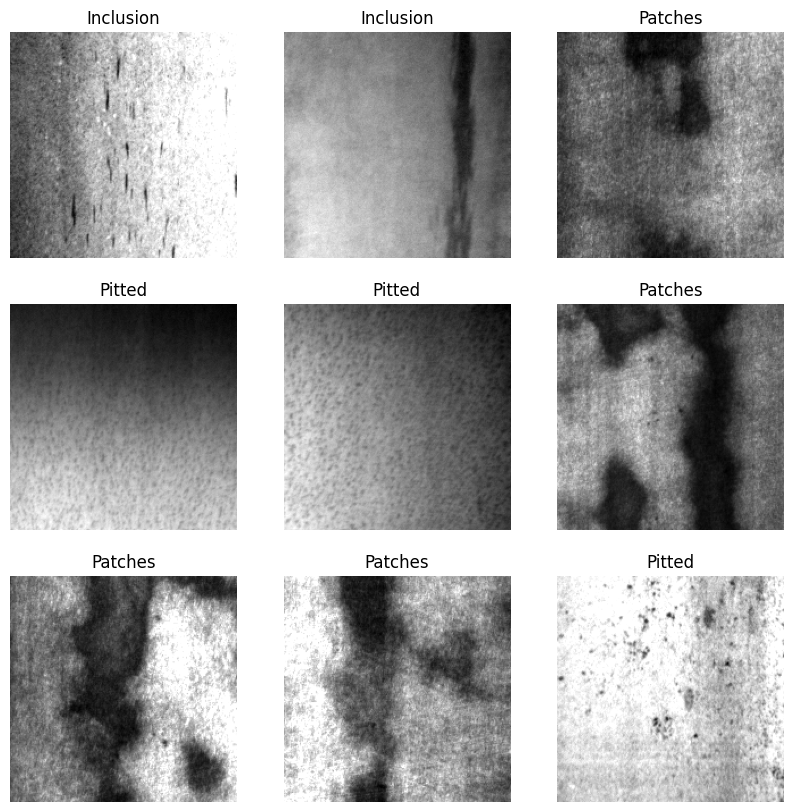

In [ ]:
N = 9
show_random_images(train_dir, N)

### Модель №1

####Чтение данных из директорий

In [ ]:
# создаем генератор данных для изображений
# масштабируем изображения с коэф-том 1./255 (RGB)

datagen = ImageDataGenerator(
    rescale = 1./255
  )

In [ ]:
# генерируем пакеты данных для указанных директорий
# масштабируем изображения до 200x200, размер батча = 10

train_data = datagen.flow_from_directory(
        train_dir,
        target_size = (200, 200),
        batch_size = 10,
        class_mode = 'categorical'
      )

validation_data = datagen.flow_from_directory(
        val_dir,
        target_size = (200, 200),
        batch_size = 10,
        class_mode = 'categorical'
      )

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


In [ ]:
test_data = datagen.flow_from_directory(
        test_dir,
        target_size = (200, 200),
        batch_size = 10,
        class_mode = 'categorical'
      )

Found 72 images belonging to 6 classes.


####Модель нейронной сети

Слои:

*   Conv2D - реализация сверточного слоя в keras. Слой свёртки включает в себя для каждого канала свой фильтр, ядро свёртки которого обрабатывает предыдущий слой по фрагментам.
*   MaxPool2D - реализация операции max pooling. Следующий слой после сверточного должен укрупнять масштаб полученных признаков, для этого чаще всего используется операция MaxPooling (в каждом окне выбирается максимальное значение).
* Слой Flatten преобразует матрицу в единый массив.
* Два полносвязных слоя Dense: 32 и classes_num нейронов, с функциями активации relu и softmax соответственно.

In [ ]:
model_1 = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(classes_num, activation='softmax')

])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 199, 199, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 313632)            0         
                                                                 
 dense (Dense)               (None, 32)                10036256  
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 10036870 (38.29 MB)
Trainable params: 10036870 (38.29 MB)
Non-trainable params: 0 (0.00 Byte)
______________

####Настройка параметров обучения

В качестве функции потерь была использована категориальная кросс-энтропия, оптимизатора - RMSprop. Качество классификатора оцениваем с помощью accuracy.

In [ ]:
model_1.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'RMSprop',
    metrics = ['accuracy']
  )

Добавим несколько callback-функций:

* early_stop_by_acc - останавливает обучением модели, если достигнута точность 0.95 на валидационной выборке.
* early_stop - остановка обучения, если точность на валидационной выборке не увеличилась в течение 5 эпох.
* checkpoint - сохранение модели с лучшими характеристиками.

In [ ]:
early_stop_by_acc = EarlyStoppingByAccuracy(
    monitor = 'val_accuracy',
    value = 0.95,
    verbose = 1
  )

In [ ]:
early_stop = EarlyStopping(
  monitor = 'val_accuracy',
  patience = 5,
  mode = 'max',
  verbose = 1
)

checkpoint_filepath_1 = path + 'models/' + 'RNN_1-{val_accuracy:.3f}.hdf5'

checkpoint = ModelCheckpoint(
  filepath = checkpoint_filepath_1,
  monitor = 'val_accuracy',
  verbose = 1,
  mode = 'max',
  save_best_only = True
)

callbacks_list = [
    early_stop,
    checkpoint,
    early_stop_by_acc
  ]

####Обучение модели

In [ ]:
history_1 = model_1.fit(
    train_data,
    # поскольку размер батча задан
    # flow_frow_directory, здесь он игнорируется (!)
    batch_size = 32,
    epochs = 20,
    validation_data = validation_data,
    callbacks = callbacks_list,
    verbose = 1,
    shuffle = True
  )

Epoch 1/20
166/166 [==============================] - ETA: 0s - loss: 3.3460 - accuracy: 0.1636
Epoch 1: val_accuracy improved from -inf to 0.16667, saving model to /content/drive/MyDrive/STUDY/магистратура курс 2/Нейронные сети/Lab_7/models/RNN_1-0.167.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


166/166 [==============================] - 63s 371ms/step - loss: 3.3460 - accuracy: 0.1636 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 2/20
166/166 [==============================] - ETA: 0s - loss: 1.7921 - accuracy: 0.1606
Epoch 2: val_accuracy did not improve from 0.16667
166/166 [==============================] - 62s 374ms/step - loss: 1.7921 - accuracy: 0.1606 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 3/20
166/166 [==============================] - ETA: 0s - loss: 1.7921 - accuracy: 0.1528
Epoch 3: val_accuracy did not improve from 0.16667
166/166 [==============================] - 61s 366ms/step - loss: 1.7921 - accuracy: 0.1528 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 4/20
166/166 [==============================] - ETA: 0s - loss: 1.7921 - accuracy: 0.1479
Epoch 4: val_accuracy did not improve from 0.16667
166/166 [==============================] - 58s 348ms/step - loss: 1.7921 - accuracy: 0.1479 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 5/20
166/166 [===

####Оценка модели

Визуализируем процесс обучения модели.

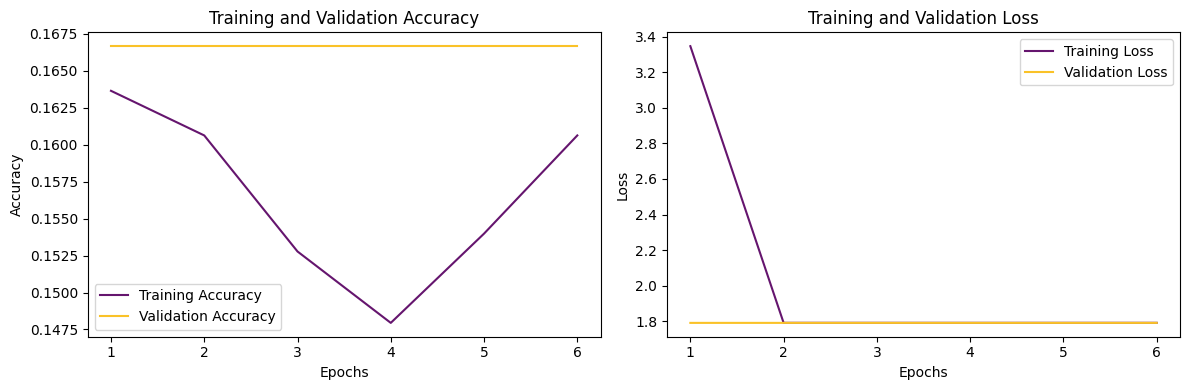

In [ ]:
acc_and_loss_visualization(history_1, colors)

Оценим модель на тестовой выборке.

In [ ]:
model_1.evaluate(test_data)

8/8 [==============================] - 1s 71ms/step - loss: 1.7918 - accuracy: 0.1667


[1.7917646169662476, 0.1666666716337204]

И отобразим на экране случайные изображения из тестовой выборки с правильными классами и теми, которые были выбраны моделью.

1/1 [==============================] - 0s 162ms/step


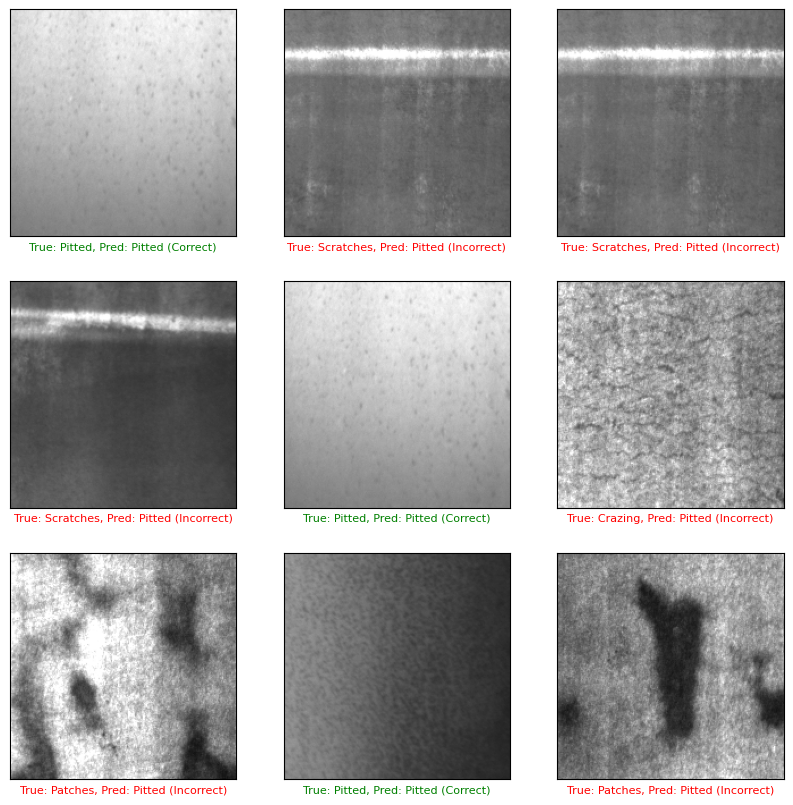

In [ ]:
display_random_preds(model_1, test_data)

### Модель №2

####Чтение данных из директорий

В классе ImageDataGenerator предоставлены API аугментации данных. Добавим обработку обучающих изображений:

* shear_range = 0.2 - интенсивность сдвига (угол сдвига против часовой стрелки в градусах).

* zoom_range = 0.2 - случайное увеличение масштаба внутри изображений.

* horizontal_flip - случайное переворачивание половины изображений по горизонтали.



In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
  )

test_datagen = ImageDataGenerator(
    rescale = 1./255
  )

In [ ]:
train_data = train_datagen.flow_from_directory(
        train_dir,
        target_size = (200, 200),
        batch_size = 10,
        class_mode = 'categorical'
      )

validation_data = test_datagen.flow_from_directory(
        val_dir,
        target_size = (200, 200),
        batch_size = 10,
        class_mode = 'categorical'
      )

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


In [ ]:
test_data = test_datagen.flow_from_directory(
        test_dir,
        target_size = (200, 200),
        batch_size = 10,
        class_mode = 'categorical'
      )

Found 72 images belonging to 6 classes.


####Модель нейронной сети

Оставим прежнюю архитектуру модели.

In [ ]:
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(classes_num, activation='softmax')
])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 199, 199, 32)      416       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 99, 99, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 313632)            0         
                                                                 
 dense_2 (Dense)             (None, 32)                10036256  
                                                                 
 dense_3 (Dense)             (None, 6)                 198       
                                                                 
Total params: 10036870 (38.29 MB)
Trainable params: 10036870 (38.29 MB)
Non-trainable params: 0 (0.00 Byte)
____________

####Настройка параметров обучения

In [ ]:
model_2.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'RMSprop',
    metrics = ['accuracy']
  )

In [ ]:
early_stop_by_acc = EarlyStoppingByAccuracy(
    monitor = 'val_accuracy',
    value = 0.95,
    verbose = 1
  )

In [ ]:
early_stop = EarlyStopping(
  monitor = 'val_accuracy',
  patience = 5,
  mode = 'max',
  verbose = 1
)

checkpoint_filepath_2 = path + 'models/' + 'RNN_2-{val_accuracy:.3f}.hdf5'

checkpoint = ModelCheckpoint(
  filepath = checkpoint_filepath_2,
  monitor = 'val_accuracy',
  verbose = 1,
  mode = 'max',
  save_best_only = True
)

callbacks_list = [
    early_stop,
    checkpoint,
    early_stop_by_acc
  ]

####Обучение модели

In [ ]:
history_2 = model_2.fit(
    train_data,
    batch_size = 32,
    epochs = 20,
    validation_data = validation_data,
    callbacks = callbacks_list,
    verbose = 1,
    shuffle = True
  )

Epoch 1/20
166/166 [==============================] - ETA: 0s - loss: 1.4199 - accuracy: 0.4106
Epoch 1: val_accuracy did not improve from 0.44444
166/166 [==============================] - 75s 448ms/step - loss: 1.4199 - accuracy: 0.4106 - val_loss: 1.3759 - val_accuracy: 0.3750
Epoch 2/20
166/166 [==============================] - ETA: 0s - loss: 1.3687 - accuracy: 0.4215
Epoch 2: val_accuracy did not improve from 0.44444
166/166 [==============================] - 90s 540ms/step - loss: 1.3687 - accuracy: 0.4215 - val_loss: 1.4540 - val_accuracy: 0.4028
Epoch 3/20
166/166 [==============================] - ETA: 0s - loss: 1.2875 - accuracy: 0.4589
Epoch 3: val_accuracy did not improve from 0.44444
166/166 [==============================] - 72s 435ms/step - loss: 1.2875 - accuracy: 0.4589 - val_loss: 1.3582 - val_accuracy: 0.4444
Epoch 4/20
166/166 [==============================] - ETA: 0s - loss: 1.2765 - accuracy: 0.4734
Epoch 4: val_accuracy improved from 0.44444 to 0.50000, savin

####Оценка модели

Выведем процесс обучения на графике.

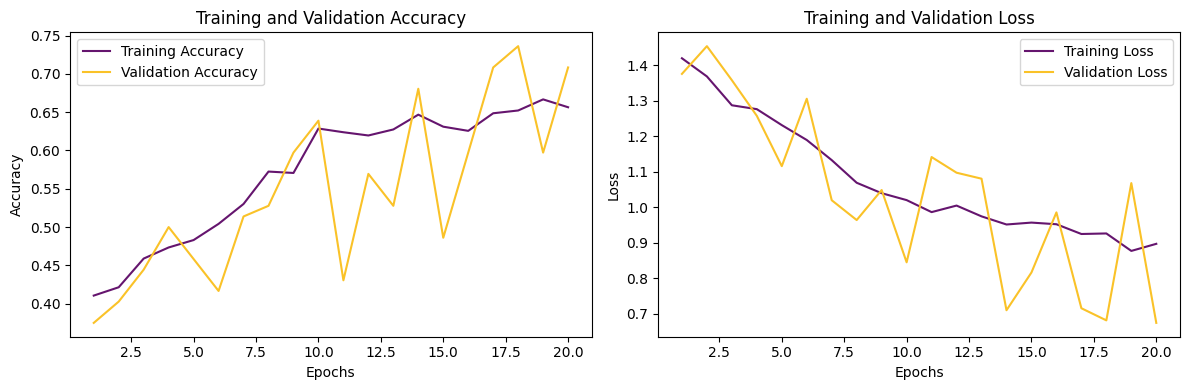

In [ ]:
acc_and_loss_visualization(history_2, colors)

По графику можно предположить, что модель является недообученной, так как Loss имеет тенденцию к уменьшению на тестовой и валидационной выборке (accuracy, соответственно, к увеличению), а модель обучалась все 20 эпох и не зачершила обучение ни по одному из callback-функций.

Оценим модель на тестовой выборке.

In [ ]:
model_2.evaluate(test_data)

8/8 [==============================] - 1s 75ms/step - loss: 0.7136 - accuracy: 0.6806


[0.7136104702949524, 0.6805555820465088]

Выведем случайные изображения из тестовой выборки.

1/1 [==============================] - 0s 210ms/step


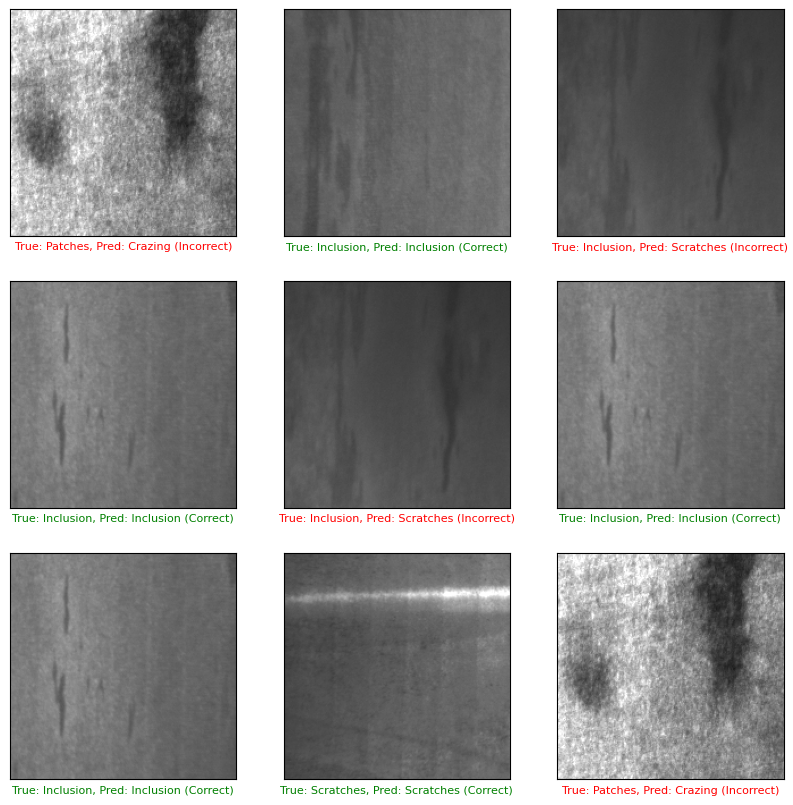

In [ ]:
display_random_preds(model_2, test_data)

### Модель №3

####Чтение данных из директорий

Так как аугемнтация сказалась положительно на обучении модели, попробуем оставить параметры разделения данных на выборки и обучения модели прежними, но изменим архитектуру модели.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
  )

test_datagen = ImageDataGenerator(
    rescale = 1./255
  )

In [ ]:
train_data = train_datagen.flow_from_directory(
        train_dir,
        target_size = (200, 200),
        batch_size = 10,
        class_mode = 'categorical'
      )

validation_data = test_datagen.flow_from_directory(
        val_dir,
        target_size = (200, 200),
        batch_size = 10,
        class_mode = 'categorical'
      )

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


In [ ]:
test_data = test_datagen.flow_from_directory(
        test_dir,
        target_size = (200, 200),
        batch_size = 10,
        class_mode = 'categorical'
      )

Found 72 images belonging to 6 classes.


####Модель нейронной сети

Добавим модель ещё два сверточных слоя с функциями активации relu и увеличим количество нейронов в полносвязном слое. Добавим также слой Dropout с вероятностью 0.2.

In [ ]:
model_3 = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(classes_num, activation='softmax')
])

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 199, 199, 32)      416       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 99, 99, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 98, 98, 64)        8256      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 49, 49, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 128)       32896     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 128)      

####Настройка параметров обучения

In [ ]:
model_3.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'RMSprop',
    metrics = ['accuracy']
  )

In [ ]:
early_stop_by_acc = EarlyStoppingByAccuracy(
    monitor = 'val_accuracy',
    value = 0.95,
    verbose = 1
  )

In [ ]:
early_stop = EarlyStopping(
  monitor = 'val_accuracy',
  patience = 5,
  mode = 'max',
  verbose = 1
)

checkpoint_filepath_3 = path + 'models/' + 'RNN_3-{val_accuracy:.3f}.hdf5'

checkpoint = ModelCheckpoint(
  filepath = checkpoint_filepath_3,
  monitor = 'val_accuracy',
  verbose = 1,
  mode = 'max',
  save_best_only = True
)

callbacks_list = [
    early_stop,
    checkpoint,
    early_stop_by_acc
  ]

####Обучение модели

In [ ]:
history_3 = model_3.fit(
    train_data,
    batch_size = 32,
    epochs = 20,
    validation_data = validation_data,
    callbacks = callbacks_list,
    verbose = 1,
    shuffle = True
  )

Epoch 1/20
166/166 [==============================] - ETA: 0s - loss: 1.8980 - accuracy: 0.2796
Epoch 1: val_accuracy improved from -inf to 0.65278, saving model to /content/drive/MyDrive/STUDY/магистратура курс 2/Нейронные сети/Lab_7/models/RNN_3-0.653.hdf5
166/166 [==============================] - 146s 870ms/step - loss: 1.8980 - accuracy: 0.2796 - val_loss: 1.2753 - val_accuracy: 0.6528
Epoch 2/20
166/166 [==============================] - ETA: 0s - loss: 1.2573 - accuracy: 0.5163
Epoch 2: val_accuracy improved from 0.65278 to 0.81944, saving model to /content/drive/MyDrive/STUDY/магистратура курс 2/Нейронные сети/Lab_7/models/RNN_3-0.819.hdf5
166/166 [==============================] - 156s 933ms/step - loss: 1.2573 - accuracy: 0.5163 - val_loss: 0.7533 - val_accuracy: 0.8194
Epoch 3/20
166/166 [==============================] - ETA: 0s - loss: 0.9315 - accuracy: 0.6745
Epoch 3: val_accuracy improved from 0.81944 to 0.86111, saving model to /content/drive/MyDrive/STUDY/магистратура

####Оценка модели

Процесс обучения завершился на 8-й эпохе, так как точность на валидационной выборке достигла заданного уровня. По графикам также можно предположить, что модель является недообученной (что действительно является так, поскольку если убрать соответствующий callback, точность возрастает до 0.99).

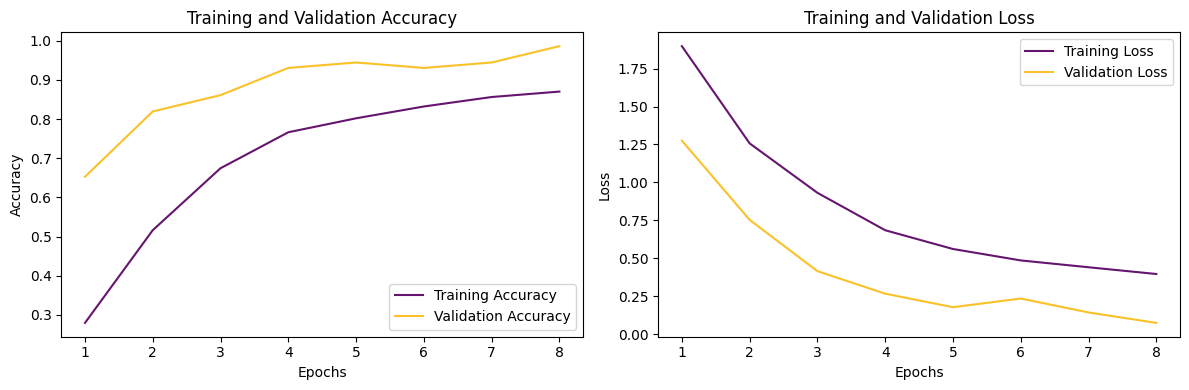

In [ ]:
acc_and_loss_visualization(history_3, colors)

При оценке на тестовой выборке accuracy составила 0.93.

In [ ]:
model_3.evaluate(test_data)

8/8 [==============================] - 2s 221ms/step - loss: 0.2365 - accuracy: 0.9306


[0.23654164373874664, 0.9305555820465088]

1/1 [==============================] - 0s 319ms/step


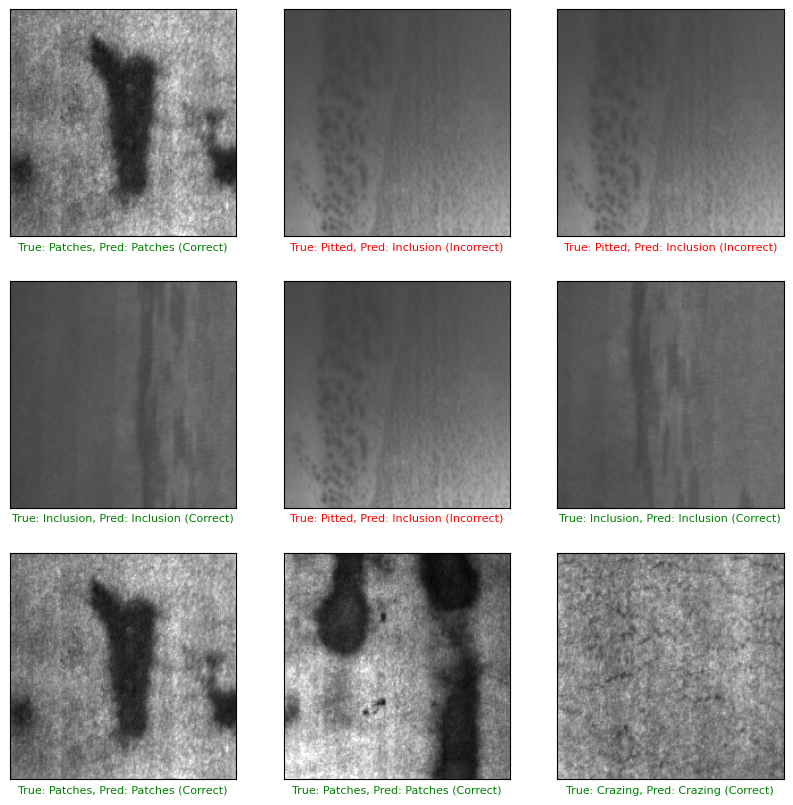

In [ ]:
display_random_preds(model_3, test_data)

###Выводы

Создадим датафрейм с точностью каждой модели на тестовой выборке.

In [ ]:
if 'scores_df' in globals():
  scores_df = scores_df[0:0]

scores_df = pd.DataFrame(columns=['model_number', 'accuracy'])

print(scores_df)

Empty DataFrame
Columns: [model_number, accuracy]
Index: []


In [ ]:
scores_df.loc[ len(scores_df.index )] = [int(1), float("{0:.3f}".format(model_1.evaluate(test_data)[1]))]
scores_df.loc[ len(scores_df.index )] = [int(2), float("{0:.3f}".format(model_2.evaluate(test_data)[1]))]
scores_df.loc[ len(scores_df.index )] = [int(3), float("{0:.3f}".format(model_3.evaluate(test_data)[1]))]

print(scores_df)

8/8 [==============================] - 1s 132ms/step - loss: 0.2365 - accuracy: 0.9306
   model_number  accuracy
0           1.0     0.167
1           2.0     0.681
2           3.0     0.931


Построим столбчатую диаграмму с указанием accuracy.

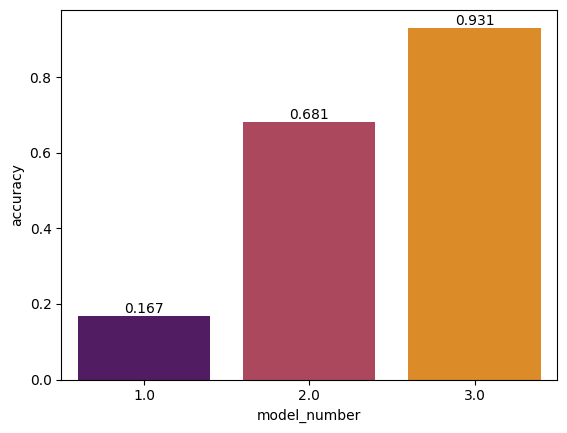

In [ ]:
g = sns.barplot(
    scores_df,
    x="model_number",
    y="accuracy",
    palette = palette
  )

for i in g.containers:
    g.bar_label(i,)

Как видим, модель с аугментацией данных и большим количеством сверточных слоёв показала лучший результат по сравнению с другими моделями.